# CIS 5450 Homework 3: Hypothesis Testing and Machine Learning

*Due Date: **October 28th at 10:00PM EST**<br>
**101 points total** (= 85 autograded + 16 manually graded).*

Welcome to CIS 5450 Homework 3! In this homework you will gain some familiarity with machine learning models for supervised learning. Over the next few days you will strengthen your understanding of hypothesis testing via simulation and ML concepts using baseball, insurance, and diabetes datasets. Some housekeeping below!<br><br>

<center>
<img src="https://storage.googleapis.com/kaggle-forum-message-attachments/703594/14673/DATAAC.jpeg" alt="drawing" width="500"/>
</center>

**Before you begin:**
- Be sure to click "Copy to Drive" to make sure you're working on your own personal version of the homework
- Check the pinned FAQ post on Ed for updates! If you have been stuck, chances are other students have also faced similar problems.

**Note:**  We will be manually checking your implementations and code for certain problems. If you incorrectly implemented a procedure using Scikit-learn (e.g. creating predictions on training dataset, incorrectly process training data prior to running certain machine learning models, hardcoding values, etc.), we will be enforcing a penalty system up to the maximum value of points allocated to the problem. (e.g. if your problem is worth 4 points, the maximum number of points that can be deducted is 4 points).
  - **Note:** If your plot is not run or not present after we open your notebook, we will deduct the entire manually graded point value of the plot. (e.g. if your plot is worth 4 points, we will deduct 4 points).
  - **Note:** If your `.py` file is hidden because it's too large, that's ok! We only care about your `.ipynb` file.

# Part 0. Import and Setup

Import necessary libraries (do not import anything else!)

In [278]:
%%capture
!pip3 install penngrader-client

In [279]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import random
import math
from xgboost import XGBClassifier
from penngrader.grader import *

In [280]:
!apt install zstd
!wget -nc -O diabetes_prediction_dataset.csv.zst https://www.dropbox.com/scl/fi/p8qpv4eja0xp3cdk1tbm5/diabetes_prediction_dataset.csv.zst?rlkey=m4i34s7xdkj28qp4vuqxo6e1w&st=8ztjoyba&dl=0
!unzstd -f diabetes_prediction_dataset.csv.zst
!wget -nc -O games.csv.zst https://www.dropbox.com/scl/fi/43au9nv0bty84pqg6aw64/games.csv.zst?rlkey=k89euspbzgnonringupktifrd&st=swgk8p7v&dl=0
!unzstd -f games.csv.zst
!wget -nc -O medical_cost.csv.zst https://www.dropbox.com/scl/fi/8nz07htxxi07xilddsulx/medical_cost.csv.zst?rlkey=946kksokbm7u29rftvqhzzi0w&st=piwysilw&dl=0
!unzstd -f medical_cost.csv.zst

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zstd is already the newest version (1.4.8+dfsg-3build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
File ‘diabetes_prediction_dataset.csv.zst’ already there; not retrieving.
diabetes_prediction_dataset.csv.zst: 4130283 bytes 
File ‘games.csv.zst’ already there; not retrieving.
games.csv.zst       : 7265422 bytes 
File ‘medical_cost.csv.zst’ already there; not retrieving.
medical_cost.csv.zst: 55628 bytes 


###PennGrader Setup

In [281]:
# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW
# TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 86393681 # YOUR PENN-ID GOES HERE AS AN INTEGER #
SECRET = STUDENT_ID

In [282]:
%%writefile config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Overwriting config.yaml


In [283]:
%set_env HW_ID=cis5450_fall24_HW3

env: HW_ID=cis5450_fall24_HW3


In [284]:
grader = PennGrader('config.yaml', 'cis5450_fall24_HW3', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 86393681

Make sure this correct or we will not be able to store your grade


# Part 1: Hypothesis Testing via Simulation [17 Points Total]

## 1.1: Estimating Pi through Simulation [4 points]

Consider a circle with radius 1/2 inside of a unit square:

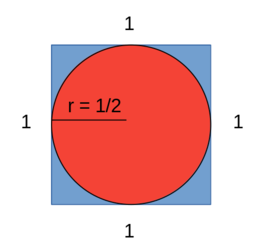

We could compute the area of the circle with a well-known formula and the value of $\pi$, but we can also compute both the area of the circle, and the mysterious value of $\pi$, via simulation!

If we randomly sample a point inside the unit square, the probability that the point falls within the circle is equal to the area of the circle divided by the area of the square. Thus, if we sample a total of $P_t$ points and $P_c$ of them are in the circle, we can write the area of the circle $A_c$ as:

$A_c = \frac{P_c}{P_t} = \pi r^2 = \frac{\pi}{4}$

Solving for $\pi$ gives:

$\pi = \frac{4 P_c}{P_t}$

Below is some Python code that simulates picking a random point in the square, testing if that point is inside the circle, and keeping track of $P_c$ and $P_t$. Run this code to ensure it works, and see how long it takes. The simulation should sample 10 million points.

In [285]:
%%time
def pt_in_circle(x, y):
    return math.sqrt(x**2 + y**2) < 0.5

p_c = 0
p_t = 0

for i in range(10_000_000):
    # Sample x and y uniformly from -0.5 to 0.5
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if pt_in_circle(x, y):
        p_c += 1
    p_t += 1

# Estimate pi
pi_estimate = 4 * p_c / p_t
print(f"Estimated value of pi: {pi_estimate}")

Estimated value of pi: 3.1410688
CPU times: user 21.6 s, sys: 51.8 ms, total: 21.6 s
Wall time: 55.3 s


Next, let's accelerate our simulation with vectorization! Using `numpy`, write a vectorized version of the simulation.

Your solution must:
* Contain no loops (`while`, `for`, etc.) or list comprehensions
* Contain no if statements or conditionals
* Only use built-in or numpy `np.` functions
* Should make only a single call to `np.random`.

*Note:* You will not get any credit if you violate any of the above instructions.

In [286]:
%%time
import numpy as np

# Sample 10,000,000 points uniformly from -0.5 to 0.5 for both x and y
points = np.random.uniform(-0.5, 0.5, size=(10_000_000, 2))

# Calculate the distances of all points from the origin
distances = np.sqrt(np.sum(points**2, axis=1))

# Count how many points are inside the circle (distance < 0.5)
points_in_circle = np.sum(distances < 0.5)

# Estimate pi
pi_estimate = 4 * points_in_circle / len(points)

print(f"Estimated value of pi: {pi_estimate}")


Estimated value of pi: 3.1421248
CPU times: user 451 ms, sys: 168 ms, total: 619 ms
Wall time: 619 ms


## 1.2 Hypothesis Testing [13 Points]

It is commonly believed that in many sports, the home team tends to have an advantage over the away team, often referred to as "home field advantage." In this part, we will perform a hypothesis test to determine, from a statistical standpoint, if such an advantage exists in Major League Baseball (MLB) games. We will guide you through each step of the process, using the MLB Games Dataset, and conduct the test through simulation. For this part, we will be using vectorization only, so no `for` loops should be used!

### 1.2.1 Load Data

Before diving into the simulation, we need to load in the data first.

**TODO:**


*   Load `games.csv` and save the data to a dataframe called `games_df`.
*   Inspect the first five rows. There are many columns in this dataframe, but think about which ones we will actually need for hypothesis testing.





In [287]:
# DO NOT CHANGE
# Import Data
games_df = pd.read_csv("games.csv")
games_df.head()


,Game,away,away-record,awayaway-record,home,home-record,homehome-record,away-score,home-score,postseason info,...,LOSS - Pitcher - Id,LOSS - Pitcher - Name,LOSS - Pitcher - AbbrName,LOSS - Pitcher - Record,SAVE - Pitcher - Stats,SAVE - Pitcher - Id,SAVE - Pitcher - Name,SAVE - Pitcher - AbbrName,SAVE - Pitcher - Record,Extra Innings
0,360403123,STL,0-1,0-1 Away,PIT,1-0,1-0 Home,1.0,4.0,NaN,...,5403.0,Adam Wainwright,A. Wainwright,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
1,360403130,TOR,1-0,1-0 Away,TB,0-1,0-1 Home,5.0,3.0,NaN,...,31003.0,Chris Archer,C. Archer,(0-1),"1.0 IP, 0 ER, 2 K, 0 BB",32693.0,Roberto Osuna,R. Osuna,(1),NaN
2,360403107,NYM,0-1,0-1 Away,KC,1-0,1-0 Home,3.0,4.0,NaN,...,31214.0,Matt Harvey,M. Harvey,(0-1),"1.0 IP, 0 ER, 2 K, 1 BB",28957.0,Wade Davis,W. Davis,(1),NaN
3,360404108,SF,1-0,1-0 Away,MIL,0-1,0-1 Home,12.0,3.0,NaN,...,31140.0,Wily Peralta,W. Peralta,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
4,360404101,MIN,0-1,0-1 Away,BAL,1-0,1-0 Home,2.0,3.0,NaN,...,29265.0,Kevin Jepsen,K. Jepsen,(0-1),NaN,NaN,NaN,NaN,NaN,NaN


In lecture, you have learned that in hypothesis testing, we start by assuming a baseline called the null hypothesis. For this test, the null hypothesis ($H_0$) is that home field advantage does not exist in MLB games. This means that, under the null hypothesis, the probability of the home team winning is equal to the probability of the away team winning (i.e., 50%).

As a brief review, to determine whether we can reject or fail to reject the null hypothesis, we will:

1.   Set up the hypotheses:
  * $H_0$: The probability of the home team winning is 50% (no home field advantage).
  * $H_a$ (alternative hypothesis): The probability of the home team winning is greater than 50% (home field advantage exists).

2.   Analyze the data: We will calculate the observed proportion of home team wins using the MLB Games Dataset.

3. Simulate random outcomes: We will simulate a large number of seasons where home teams win exactly 50% of the time, assuming the null hypothesis is true. In lecture you saw the Gaussian distribution. Here, the nature of the data requires us to draw from the binomial distribution.

4. Compare observed results to simulations: We will determine how often the simulated results produce home win rates as extreme or more extreme than the observed data. This will give us a **p-value**, which tells us the likelihood of observing the current data under the null hypothesis.

5. Make a decision: Based on the p-value, we will decide whether to reject or fail to reject the null hypothesis:
  * If the p-value is below a threshold (in this case we'll use 0.05), we will reject the null hypothesis and conclude that home field advantage likely exists. Intuitively, a small p-value means that the data we observed is extremely unlikely to occur under the null hypothesis.
  * If the p-value is higher, we will fail to reject the null hypothesis, meaning the evidence is not strong enough to suggest home field advantage.

### 1.2.2 Calculate Original Test Statistic [3 Points]

We will now move on to Step 2, which is to calculate the original test statistic, i.e., the home win rate of the given data.

**TODO:**

*   Under special circumstances, there can be a tie. For this part, just drop games that ended in a tie.
*   Create a column called `home_win` that is a 1 if the home team won that game and 0 otherwise.
*   Calculate the proportion of times that the home team wins and store it in `home_win_rate`

In [350]:
# Drop ties and reset index
games_df = games_df[games_df['home-score'] != games_df['away-score']]
games_df = games_df.reset_index(drop = True)

# Create a column that is 1 if the home team won
games_df['home_win'] = (games_df['home-score'] > games_df['away-score']).astype(int)

# Calculate original test statistic
home_win_rate = games_df['home_win'].mean()

In [351]:
# Grader Cell (3 points)
grader.grade(test_case_id = 'original_test_statistic', answer = (games_df['home_win'], home_win_rate))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.3 Simulation and Plotting [7 points] (7 manually graded)

Now we will simulate the null world to get a distribution.

**TODO:**
* Simulate 10,000,000 trials
* Each trial should be drawn from a binomial distribution. If you are unfamiliar with the binomial distribution, take a look at the numpy documentation and pay careful attention to what your `n` and `p` should be in this case. Recall what it means when we are sampling from the null world.
* Calculate the simulated proportion by dividing by total games

*Note:* You should be using `numpy` vectorization

In [352]:
# Simulate random home win outcomes for each game across all simulations
num_games = len(games_df)
num_simulations = 10_000_000
new_home_win_rate = 0.5
simulated_home_wins = np.random.binomial(n=num_games, p=new_home_win_rate, size=10_000_000)

# Calculate the simulated proportion of home wins
simulated_win_rates = simulated_home_wins /num_games


Now, let's visualize the distribution of our simulation.

**Task:**


*   Plot a histogram of the distribution of the test statistic in the null world. Use 50 bins.
*   Title the plot: *Distribution of Simulated Home Winrate*
*   Label the x-axis: *Home Winrate*
*   Label the y-axis: *Frequency*
*   Add a red vertical line to indicate the original test statistic. Label this vertical line "Observed Home Winrate: {home_win_rate}". Round to four decimal points.
*   Add a legend to your plot.

*Hint:* Take a look at `matplotlib.pyplot.axvline`



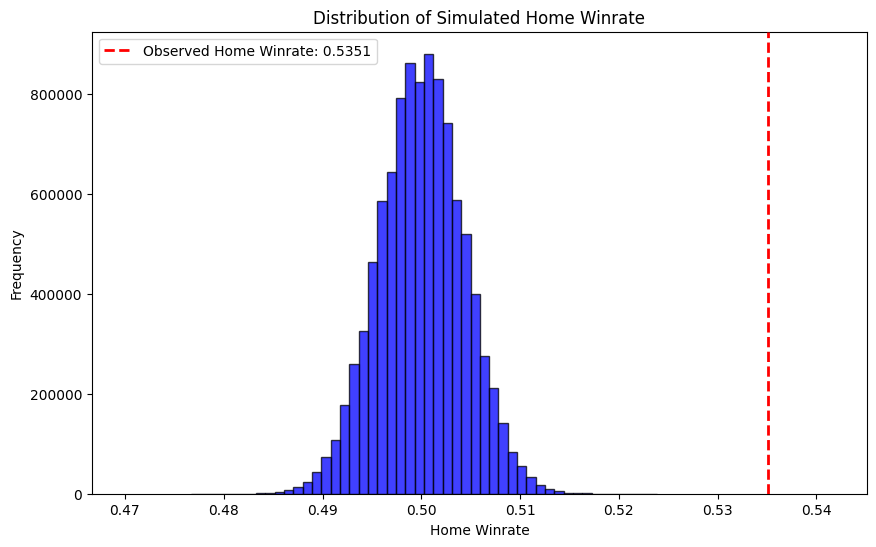

In [361]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(simulated_win_rates, bins=50, alpha=0.75, color='blue', edgecolor='black')

# Add the red line with higher zorder (ensures it is rendered on top)
plt.axvline(x=home_win_rate, color='red', linestyle='dashed', linewidth=2,
            label=f'Observed Home Winrate: {home_win_rate:.4f}', zorder=10)

# Adjust the x-axis to ensure all elements are visible
plt.xlim(min(min(simulated_win_rates), home_win_rate) - 0.01,
         max(max(simulated_win_rates), home_win_rate) + 0.01)

# Add title and labels
plt.title('Distribution of Simulated Home Winrate')
plt.xlabel('Home Winrate')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()






### 1.2.4 Calculate p-value [3 points] (2 manually graded)

Finally, we can calculate the simulated p-value. Remember what the p-value represents, and use your simulated win rates to calculate it.

In [354]:
# Calculate the p-value
simulated_p_value = (simulated_win_rates >= home_win_rate).mean()
print(f"Simulated p-value: {simulated_p_value}")

Simulated p-value: 0.0


In [355]:
# Grader Cell (1 points)
grader.grade(test_case_id = 'test_p_value', answer = simulated_p_value)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


After calculating the p-value, **briefly** describe what it represents. Does the p-value represent exactly what you might get if you were to calculate it mathematically? State whether we should reject or fail to reject the null hypothesis.

**Answer:**  We are comparing the simulated win rates under the null hypothesis to the observed home win rate. Since P value is 0 we can reject the Null Hypothesis.

# Part 2. Linear Regression and Hypothesis Testing [Total 40 points]

## 2.1 Load and Proprocess regression data [20 Points]
In this section, we will use the [medical cost dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance/data) to explore linear regression, interpret its results, and perform coefficients hypothesis testings.

In supervised machine learning, regression and classification are two foundational tasks. While classification focuses on predicting discrete labels or categories, regression is concerned with predicting continuous values. One of the simplest and most widely used techniques for regression is linear regression, which models the relationship between input features and a continuous target variable by fitting a linear equation to the data.

In [205]:
# DO NOT CHANGE
# Import Data
medical_cost_df = pd.read_csv('medical_cost.csv')
medical_cost_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 2.1.1 Train-Test-Split [2 points]

The overall goal of this regression tasks is the use the independent variables we have (age, sex, bmi, children number, smoker, and region) to make a prediction on charges.<br>
**Features / Independent Variables** (before any feature processing): age, sex, bmi, children, smoker, region<br>
**Target Variable:** charges


---


Conduct a train-test split, assigning **80%** of the data to the training set and the remaining **20%** to the testing set. This ensures that the encoding and scaling we perform later are fitted only on the training data, preventing any spillover from the test data.

- Name the outputs as `X_train`, `X_test`, `y_train`, and `y_test`.
- Set the variable **random_seed** to 42, and then pass the argument `random_state = 42` in the function to fix the random state, ensuring consistency in our results.

The documentation of train_test_split can be found: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [206]:
from IPython.display import clear_output
clear_output()

In [207]:
import pandas as pd
from sklearn.model_selection import train_test_split

# TODO: perform train_test_split on medical_cost_df
X = medical_cost_df.drop('charges', axis=1)  # Features
y = medical_cost_df['charges']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [208]:
# Grader Cell (2 points)
grader.grade(test_case_id = 'mc_train_test_split', answer = (X_train, X_test, y_train, y_test))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.1.2 Encode [5 points]
For linear regression to run, it only accepts numerical values, so we need to convert all non-numerical columns in the `X_train` and `X_test` into numerical ones. There are several encoding methods available for this process, such as [LabelEncoder](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), and [OrdinalEncoder](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). You can explore the differences between these methods through the following articles: [Article 1](https://medium.com/@chandradip93/difference-between-one-hot-encoding-and-label-encorder-5ad16ea719bc#:~:text=In%20summary%2C%20LabelEncoder%20assigns%20a,column%20represents%20a%20unique%20category) and [Article 2](https://www.geeksforgeeks.org/what-is-the-difference-between-ordinalencoder-and-labelencoder/).

For this dataset, we will be using [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) because there is no ordinal information we want to preserve, and binary encoding will better support our later interpretations.

Note:
- The onehotencoder object instantiated should be only fitted on the training data
- Include `sparse_output = False` when initializing `OneHotEncoder` to get a dense matrix. Depending on your version of scikit-learn, this argument may be `sparse = False`
- Include `drop = 'first'` in the `OneHotEncoder` initialization to avoid multicollinearity in the linear regression model

In [209]:
# DO NOT EDIT
# use this order of columns in the transformation below
to_encode = ['sex', 'smoker', 'region'] # columns that need to encode
not_encode = ['age', 'bmi', 'children']

In [210]:
# TODO: instantiate OneHotEncoder object,
encoder = OneHotEncoder(drop='first', sparse_output=False)

# TODO: fit & transform on the relevant columns from X_train
# TODO: transform on the relevant columns from X_test
X_train_encoded = encoder.fit_transform(X_train[to_encode])
X_test_encoded = encoder.transform(X_test[to_encode])

# Reset index of numerical columns to ensure proper concatenation
X_train_numeric = X_train[not_encode].reset_index(drop=True)
X_test_numeric = X_test[not_encode].reset_index(drop=True)



In [211]:
# TODO: Convert the encoded NumPy array back into a DataFrame with column names
#       use the get_feature_names_out method from the ohe object to get column names for the df
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(to_encode))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(to_encode))

In [212]:
# DO NOT EDIT
# concatenate the encoded columns with those that do not need to be transformed
X_train_encoded_full = pd.concat([X_train_encoded_df, pd.DataFrame(X_train[not_encode]).reset_index(drop = True)], axis = 1)
X_test_encoded_full = pd.concat([X_test_encoded_df, pd.DataFrame(X_test[not_encode]).reset_index(drop = True)], axis = 1)

In [213]:
# Grader Cell (5 points)
grader.grade(test_case_id = 'mc_ohe', answer = (X_train_encoded_df, X_test_encoded_df, X_train_encoded_full, X_test_encoded_full))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.1.3 Scaling [3 points]

As the final step in data pre-processing, we will prepare a scaled version of the data. Scaling refers to the process of mapping your features to a new range of values. This often helps machine learning models learn and converge faster. Some machine learning models are not *scale invariant*, meaning their ability to learn from the data can be impacted by the scale of the features. For example, models might give more influence to features with larger scales, implying that these features are more important than others, even when they should be treated with similar importance. Scaling features helps mitigate this issue.

There are several strategies for scaling, but in this section we will use **Standardization** on our continuous numerical features. Standardizing the data ensures that each feature is centered around zero ($\mu=0$) and has unit variance ($\sigma^2=1$).

**Task:**

* Apply standardization to the original numerical columns in both the training and testing datasets using `StandardScaler` from sklearn
  * Make sure to include only the original numerical columns and not the newly encoded ones
* Store the results in `X_train_scaled` and `X_test_scaled`

**Note:**

* Prevent data leakage by ensuring that scaling parameters are learned only from the training set.
* While we only transform the original numerical columns, `X_train_scaled` and `X_test_scaled` should have the same shape as `X_train_encoded_full` and `X_test_encoded_full` from the end of section 2.1.2.

In [214]:
# DO NOT EDIT
X_train_scaled = X_train_encoded_full.copy(deep = True)
X_test_scaled = X_test_encoded_full.copy(deep = True)

In [215]:
from sklearn.preprocessing import StandardScaler

# Instantiate a StandardScaler object
scaler = StandardScaler()

# Fit and transform the scaler on the numerical columns from the training data
# Replacing X_train_final with X_train_encoded_full
X_train_scaled[not_encode] = scaler.fit_transform(X_train_encoded_full[not_encode])

# Transform the numerical columns from the test data using the same scaler
# Replacing X_test_final with X_test_encoded_full
X_test_scaled[not_encode] = scaler.transform(X_test_encoded_full[not_encode])

In [216]:
from sklearn.preprocessing import StandardScaler

# Instantiate a StandardScaler object
scaler = StandardScaler()

# Fit and transform the scaler on the numerical columns from the training data
# Replacing X_train_final with X_train_encoded_full
X_train_scaled[not_encode] = scaler.fit_transform(X_train_encoded_full[not_encode])

# Transform the numerical columns from the test data using the same scaler
# Replacing X_test_final with X_test_encoded_full
X_test_scaled[not_encode] = scaler.transform(X_test_encoded_full[not_encode])

print the head of your df to see if the transformed columns' values make sense

In [217]:
X_train_scaled.head()

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children
0,0.0,0.0,1.0,0.0,0.0,0.472227,-1.756525,0.734336
1,0.0,0.0,0.0,0.0,0.0,0.543313,-1.033082,-0.911192
2,0.0,0.0,0.0,1.0,0.0,0.898745,-0.943687,-0.911192
3,0.0,0.0,0.0,1.0,0.0,-0.025379,0.622393,3.202629
4,0.0,0.0,1.0,0.0,0.0,1.040918,-1.504893,1.557100


In [218]:
# Grader Cell (3 points)
grader.grade(test_case_id = 'mc_scaling', answer = (X_train_scaled, X_test_scaled))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.1.4 Unregularized [5 points]

Use the `LinearRegression` class ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) in scikit-learn to perform Linear Regression. Initialize a Linear regression model named `lr` with default parameters, fit the model to the training set (**unscaled**), and then make predictions on the testing set.

Save your test predictions in an array named `y_pred_lr`, and report your [R-squared score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) for both train and test predictions

In [219]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# TO-DO: Initialize model with default parameters and fit it on the training set
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred_lr`
y_pred_lr = model.predict(X_test_scaled)

# TO-DO: Find the R-squared score for test and training sets
lr_score_train = r2_score(y_train, model.predict(X_train_scaled))
lr_score_test = r2_score(y_test, y_pred_lr)



In [220]:
### DO NOT EDIT
print(f"R² value for training set: {lr_score_train:.3f}")
print(f"R² value for test set: {lr_score_test:.3f}")

R² value for training set: 0.742
R² value for test set: 0.784


In [221]:
# Grader Cell (5 points)
grader.grade(test_case_id = 'mc_lr_unreg', answer = (lr_score_train, lr_score_test))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.1.5 Ridge [5 points]
Use the `Ridge` class ([documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Ridge.html))in scikit-learn to perform $L_2$ Regularized Linear Regression. Initialize a Ridge regression model named `lr_ridge` with regularization strength `alpha = 10`, fit the model to the training set, and then make predictions on both the training and testing set.

Save your test predictions in an array named `y_pred_ridge`, and report your [R-squared score](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge.score) for both train and test predictions.

**Note:**
- Recall that Ridge regression is not scale-invariant, so you should use the scaled data from section 2.1.3

In [222]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# TO-DO: Initialize the Ridge model with default parameters and fit it on the training set
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred_ridge`
y_pred_ridge = ridge_model.predict(X_test_scaled)

# TO-DO: Find the R-squared score for test and training sets
ridge_score_train = r2_score(y_train, ridge_model.predict(X_train_scaled))
ridge_score_test = r2_score(y_test, y_pred_ridge)


In [223]:
### DO NOT EDIT
print(f"R² value for training set: {ridge_score_train:.3f}")
print(f"R² value for test set: {ridge_score_test:.3f}")

R² value for training set: 0.742
R² value for test set: 0.783


In [224]:
# Grader Cell (5 points)
grader.grade(test_case_id = 'mc_lr_ridge', answer = (ridge_score_train, ridge_score_test))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Before moving on to the next section, let's quickly reflect on the regularized versus unregularized linear regression models and think about some relevant questions (*note this exercise is NOT graded, just for your own exercise*):

1. When would we prefer L1 (LASSO) instead of L2? Recall that L1 (LASSO) versus L2 (Ridge) regularization: L1 is for sparisty (e.g., when you have more features than data points) and L2 is to encode an assumption that no input has drastically larger impact than another.
2. What do you notice about the $R^2$ scores of the Ridge and unregularized Linear Regression above? If Ridge is supposed to "improve" Linear Regression, we may find it unusual if that is not happening here. Under what circumstances would we consider using Ridge over unregularized Linear Regression
3. Would you expect different results if we made alpha bigger ( 𝛼→∞ )? smaller ( 𝛼→0 )? Why or why not?

## 2.2 Descriptive Model [10 Points]

Different from predictive model, for descriptive model we DO NOT perform train-test-split. The model is run on the whole set of data availbale.

### 2.2.1 Pre-process data for descriptive model [3 points]

Recall that in Sections 2.1.2 and 2.1.3, encoding and scaling are applied to the training set. However, since the descriptive model uses the entire dataset, encoding and scaling should be applied to the ***full*** dataset, with all other requirements remaining the same.

- Encoding
  - Include sparse_output = False when initializing OneHotEncoder to get a dense matrix. Depending on your version of scikit-learn, this argument may be sparse = False
  - Include drop = 'first' in the OneHotEncoder initialization to avoid multicollinearity in the linear regression model
- Scaling
  - Apply standardization to the original numerical columns in both the training and testing datasets using StandardScaler from sklearn
  - Make sure to include only the original numerical columns and not the newly encoded ones
- Save your final output of processed x to `medical_x_processed`

In [225]:
# DO NOT EDIT
medical_x = medical_cost_df.drop(columns = ["charges"])
medical_y = medical_cost_df['charges']

to_encode = ['sex', 'smoker', 'region'] # columns that need to encode
not_encode = ['age', 'bmi', 'children']

In [226]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Assuming `medical_x` is the DataFrame with the original data

# TODO: Instantiate OneHotEncoder object
ohe = OneHotEncoder(drop='first', sparse_output=False)

# TODO: Fit and transform the encoder on the relevant columns from medical_x
to_encode = ['sex', 'smoker', 'region']  # Relevant columns to encode
not_encode = ['age', 'bmi', 'children']  # Columns to retain

# Fit and transform only on the relevant categorical columns
medical_x_encoded = ohe.fit_transform(medical_x[to_encode])

# TODO: Convert the encoded NumPy array back into a DataFrame with column names
X_train_encoded_df = pd.DataFrame(
    medical_x_encoded, columns=ohe.get_feature_names_out(to_encode)
)

# DO NOT EDIT this line
medical_x_processed = pd.concat(
    [X_train_encoded_df, pd.DataFrame(medical_x[not_encode]).reset_index(drop=True)],
    axis=1
)

# TODO: Instantiate a StandardScaler object
scaler = StandardScaler()

# TODO: Fit and transform the scaler on the numerical columns from the training data
medical_x_processed[not_encode] = scaler.fit_transform(
    medical_x_processed[not_encode])



In [227]:
# Grader Cell (3 points)
grader.grade(test_case_id = 'mc_descriptive_process', answer = (medical_x_processed, medical_y))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.2 Linear Regression [2 points]

Use the `LinearRegression` class ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) in scikit-learn to perform Linear Regression. Initialize a Linear regression model named `lr_descriptive` with default parameters, fit the model to `medical_x_process` and `medical_y`, and report your [R-squared score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) between `medical_x_process` and `medical_y`

In [228]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# TO-DO: Initialize model with default parameters and fit it on the training set
model = LinearRegression()
model.fit(X_train_scaled, y_train)  # Assuming `X_train_scaled` and `y_train` are defined

# TO-DO: Find the R-squared score for the test set and store the value in `lr_score_descriptive`
lr_score_descriptive = r2_score(y_test, model.predict(X_test_scaled))  # Assuming `y_test` and `X_test_scaled` are defined



In [229]:
# Grader Cell (2 points)
grader.grade(test_case_id = 'mc_lr_descriptive', answer = (lr_score_descriptive))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.3 Interpreting Coefficients [5 points] (manually graded)
**Task**
1. Print out the coefficients of the descriptive linear regression model from Section 2.2.3 along with the feature names in a DataFrame:

| feature | coefficient |
|---------|----------|
|    sex_male     |   -18.591692    |
|    smoker_yes   |    23651.128856  |
|    region_northwest        |  -370.677326   |
|    region_southeast |    -657.864297      |
|   region_southwest     |    -809.799354   |
|    age     |    3614.975415      |
|    bmi     |    2036.228123      |
|    children     |    516.890247      |


2. Explain how smoking and age affect the cost
**ANSWER** - for a unit increase in smoker_yes feature (that means if person does smoke) insurance costs increase by 23651.128856, while for a unit increase in age insurance costs increase by 3614.975415 (everything else held constant).



**Note**
1. Answer this question based on the coefficients of the model (e.g., if feature x increases by 1, how does that affect the cost?). Think about whether phrases like "smoker_yes increases by 1" make sense; consider what an increase of 1 means for the scaled columns. Be explicit in explaining its meaning.
2. reference of getting the coefficients from linear regression models: https://www.statology.org/sklearn-regression-coefficients/
3. Consider how you might you interpret the coefficients of your scaled features vs. your one hot encoded features differently

In [230]:
import pandas as pd

# TODO 1: Print models' coefficients with matching column names
coefficients_df = pd.DataFrame({
    'feature': X_train_scaled.columns,  # Extract feature names from training data
    'coefficient': model.coef_  # Extract the coefficients from the trained model
})

# Display the DataFrame
print(coefficients_df)


            feature   coefficient
0          sex_male    -18.591692
1        smoker_yes  23651.128856
2  region_northwest   -370.677326
3  region_southeast   -657.864297
4  region_southwest   -809.799354
5               age   3614.975415
6               bmi   2036.228123
7          children    516.890247


## 2.3 Hypothesis Testing [10 Points]

### 2.3.1 Testing for *all* coefficients = 0 [5 points] (1 manually graded)


Null Hypothesis: All coefficients of the unregularized model are 0, i.e., $\beta_0 = \beta_1 = ... = \beta_n = 0$.

**Task:**  

Use the code template given, report the following:

1. `original_r2`: The original model's $R^2$ value (you can use the value reported for the training data from Section 2.2.2).
2. `simulated_r2`: An array of $R^2$ values from the permuted data linear regression simulations.
3. `all_zero_p_value`: The p-value for the given null hypothesis, calculated by the proportion of times the simulated $R^2$ is larger than the original $R^2$.

**Note:**
- Use the method covered in Lecture 10 to complete this section (comparing $R^2$ values between the original regression and simulations of regressions on permuted data).
- Do **NOT** use any additional imports.
- We will manually check the code used and deduct points if necessary.
- start from `medical_x_processed` and `medical_y`

In [231]:
from sklearn.utils import resample
from sklearn.metrics import r2_score


model.fit(medical_x_processed, medical_y)

# TODO: Calculate the original R^2 score
original_r2 = r2_score(medical_y, model.predict(medical_x_processed))

# TODO: Simulate R^2 values using permuted data
simulated_r2 = []

for _ in range(1000):
    # Shuffle to break any association
    medical_y_permuted = resample(medical_y, random_state=42)

    # Fit a new model
    model.fit(medical_x_processed, medical_y_permuted)

    # Calculate the R^2 score for the permuted model
    r2 = r2_score(medical_y_permuted, model.predict(medical_x_processed))
    simulated_r2.append(r2)

# TODO: Calculate the p-value
all_zero_p_value = sum(1 for r2 in simulated_r2 if r2 >= original_r2) / len(simulated_r2)


print(f"Original R^2: {original_r2}")
print(f"P-value: {all_zero_p_value}")


Original R^2: 0.7509130345985207
P-value: 0.0


In [232]:
# Grader Cell (4 points)
grader.grade(test_case_id = 'mc_all_zero', answer = (simulated_r2, all_zero_p_value, original_r2))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**TODO [Manually graded: 1 point]**

Q: should we reject the null hypothesis

A: yes, reject the null hypothesis

### 2.3.2  Testing for one particular coefficient is zero [5 points] (1 manually graded)
Null hypothesis: The coefficient of `sex_male` in the full unregularized linear regression is 0.

**Task:**  

Use the code template given, report the following:

1. `observed_r2`: The $R^2$ value when the linear regression is done without `sex_male` feature.
2. `simulated_r2_one`: An array of $R^2$ values from residual testing linear regressions
3. `one_zero_p_value`: The p-value for the given null hypothesis, calculated by the proportion of times the simulated $R^2$ is larger than the original $R^2$.

**Note:**
- Use the residual testing method covered in Lecture 10 to complete this section.
- Do **NOT** use any additional imports.
- We will manually check the code used and deduct points if necessary.
- start from `medical_x_processed` and `medical_y`

In [233]:

from sklearn.metrics import r2_score


# TODO: Linear regression without the sex_male feature
# Exclude 'sex_male' from the feature set
X_without_sex_male = medical_x_processed.drop(columns=['sex_male'])

# Train the linear regression model without 'sex_male'
lr_without_sex_male = LinearRegression()
lr_without_sex_male.fit(X_without_sex_male, medical_y)

# Calculate observed R² without 'sex_male'
observed_r2 = r2_score(medical_y, lr_without_sex_male.predict(X_without_sex_male))


simulated_r2_one = []

# Perform residual testing 1000 times
for _ in range(1000):

    residuals = medical_y - lr_without_sex_male.predict(X_without_sex_male)


    shuffled_residuals = np.array(residuals)
    np.random.shuffle(shuffled_residuals)


    T = lr_without_sex_male.predict(X_without_sex_male) + shuffled_residuals


    lr_simulated = LinearRegression()
    lr_simulated.fit(medical_x_processed, T)


    simulated_r2 = r2_score(T, lr_simulated.predict(medical_x_processed))
    simulated_r2_one.append(simulated_r2)

# TODO: Calculate p-value based on the observed and simulated R² values
one_zero_p_value = np.mean(np.array(simulated_r2_one) >= observed_r2)

print(f"Observed R² (without sex_male): {observed_r2}")
print(f"P-value for the null hypothesis: {one_zero_p_value}")


Observed R² (without sex_male): 0.7508838801843356
P-value for the null hypothesis: 0.595


In [234]:
# Grader Cell (4 points)
grader.grade(test_case_id = 'mc_one_zero', answer = (simulated_r2_one, one_zero_p_value, observed_r2))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**TODO [Manually graded: 1 point]**

Q: should we reject the null hypothesis

A: no, cannot reject the null hypothesis

# Part 3: Imbalanced Classification and Hyperparameter Tuning [44 Points]

## 3.1: Load Data
For this part, we will be using the Diabetes prediction dataset from Kaggle. This dataset contains 9 columns and about 100K rows.

We will start by loading the data. We note that there are some rows where the `smoking_info` column has a value of 'No Info'. This isn't particularly helful to us when we're trying to make our predictions. We will start by removing these rows from our dataset.

In this section, we perform the following tasks for you. Please run all cells in this section before proceeding to the next.
*   Load the dataset called `diabetes_prediction_dataset.csv` using `pd.read_csv()`
*   Keep only the rows where `smoking_history != 'No Info'`
*   Reset index
*   Save your output in `diabetes_cleaned_df`


**There is nothing to do in this section -- but you must run all cells before proceeding.**

In [235]:
# DO NOT CHANGE
# Import Data
diabetes_path = "diabetes_prediction_dataset.csv"
diabetes_df = pd.read_csv(diabetes_path)
diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,no,yes,never,25.19,6.6,140,no
1,Female,54.0,no,no,No Info,27.32,6.6,80,no
2,Male,28.0,no,no,never,27.32,5.7,158,no
3,Female,36.0,no,no,current,23.45,5.0,155,no
4,Male,76.0,yes,yes,current,20.14,4.8,155,no


In [236]:
# Get an overview of the data
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  object 
 3   heart_disease        100000 non-null  object 
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 6.9+ MB


In [237]:
# DO NOT MODIFY
# Drop all rows where smoking-history is 'No Info' and reset_index
diabetes_cleaned_df = diabetes_df[diabetes_df['smoking_history'] != 'No Info']
diabetes_cleaned_df.reset_index(drop=True, inplace=True)
diabetes_cleaned_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,no,yes,never,25.19,6.6,140,no
1,Male,28.0,no,no,never,27.32,5.7,158,no
2,Female,36.0,no,no,current,23.45,5.0,155,no
3,Male,76.0,yes,yes,current,20.14,4.8,155,no
4,Female,20.0,no,no,never,27.32,6.6,85,no


## 3.2: Data Pre-Processing & Feature Engineering [16 Points]

In a typical machine learning project, it's crucial to carefully process and analyze your data to understand the features you're working with. However, for this homework, the focus will be more on modeling rather than Exploratory Data Analysis (EDA). We've provided a dataset that is nearly ready for use, so you won't need to spend much time on EDA here.

However, this doesn’t mean you should skip EDA in your own projects! EDA will be an essential part of your project deliverables.


### 3.2.1: Encoding Categorical Features [8 Points]
Looking at our column types, we see that we have some features of type object, some of type int64, and some of type float64. Let's start by separating the two.

**Task:**
*   Create two lists containing the column names of `numerical` and `categorical` features named `numerical_features` and `categorical_features` respectively
*   Sort these lists alphabetically

**Hint:**
* Consider using `.select_dtypes` from Pandas.

**Note:**
* Though `diabetes` is not a feature (it is our target), please include it within one of the lists you create. We will address this later when we create our test-train split.

In [238]:
# TODO: Populate the following lists
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes'	]
numerical_features.sort()
categorical_features.sort()
# DO NOT CHANGE ----------------------------------------------------------------
print(f'There are {len(categorical_features)} categorical variables')
print(f'There are {len(numerical_features)} numerical variables')
# DO NOT CHANGE ----------------------------------------------------------------

There are 5 categorical variables
There are 4 numerical variables


In [239]:
# Grader Cell (2 points)
grader.grade(test_case_id='num_cat_features', answer=(numerical_features, categorical_features))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now, let's zoom in on the categorical variables. We want to do some encoding as we did in Part 2.

\\

We will begin by casting the columns containing binary variables as strings (no/yes) to integer values (0 and 1).


**Task:**
*   Create a copy of the `diabetes_cleaned_df` and save it as `binary_diabetes_df`.
*   Identify all columns that have binary features (2 unique values)
*   Encode the columns with binary features as *float* values (0.0 and 1.0) using the `OneHotEncoder` from sklearn. [Here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is the documentation once again.
*   Save the results in `binary_diabetes_df`.


**Hint:**
*   Consider using the Pandas function `.nunique()` to see which columns have 2 values
*   `binary_diabetes_df` should have the same dimensions/shape before and after encoding. If not receiving full points, consider swapping the encoding scheme (swapping which values get the 0s and 1s)
*   Use the `drop='if_binary'` and `sparse_output=False` parameters for the One Hot Encoder
*   Please reorder the columns as follows: `['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']`

In [240]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# TODO: Create a copy of diabetes_cleaned_df and store it in binary_diabetes_df
binary_diabetes_df = diabetes_cleaned_df.copy()

# TODO: For every column in diabetes_cleaned_df, see if it has 2 unique values
# If so, save it to the binary_cols list
binary_cols = [col for col in binary_diabetes_df.columns if binary_diabetes_df[col].nunique() == 2]

In [241]:
# Grader Cell (1 point)
grader.grade(test_case_id='binary_features', answer=binary_cols)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [242]:
# TODO: Create encoder
binary_encoder = OneHotEncoder(drop='if_binary', sparse_output=False, dtype=float)

# Fit and transform the binary columns using the encoder
encoded_binary = binary_encoder.fit_transform(binary_diabetes_df[binary_cols])

# Convert the encoded binary array to a DataFrame
encoded_binary_df = pd.DataFrame(encoded_binary, columns=binary_cols)

# Replace the original binary columns with the encoded ones
binary_diabetes_df[binary_cols] = encoded_binary_df

# TODO: Reorder columns as specified
binary_diabetes_df = binary_diabetes_df[
    ['gender', 'age', 'hypertension', 'heart_disease',
     'smoking_history', 'bmi', 'HbA1c_level',
     'blood_glucose_level', 'diabetes']
]


In [243]:
# Grader cell (2 points)
grader.grade(test_case_id='binary_encodings', answer=binary_diabetes_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


While this takes care of the binary features, we still have other categorical columns.

There are two types of such features: ordinal and nominal. Ordinal features have a clear ordering among their categories (i.e., good, neutral, bad, can be ordered, while gender would be nominal). As such, encoding this data requires some way to represent that good is closer to neutral than it is to bad.

For ordinal features, we use Ordinal Encoding, which replaces all categorical values with increasing integers starting at 0.

For nominal features, One Hot Encodings may be used (similar to binary features). This involves converting a single feature with $k$ categories into $k$ or $k-1$ new columns of only ones and zeros -- enabling us to train models that only take numerical values as input.


This particular dataset doesn't contain any values that have a natural ordering, so we will only be using One Hot Encodings.

**Task:**
*   Identify nominal feature(s), and store them in a list of strings `unordered_features`.
*   Make a copy of `binary_diabetes_df` and save it as `encoded_diabetes_df`. Use this dataframe for the remainder of this task.
*   Apply One Hot Encoding to the `unordered_features`, and replace them in `encoded_diabetes_df`.
*   For each encoded variable, drop the first column that is produced in the One Hot Encoding scheme -- this ensures we have the minimum number of columns required to represent our data.
*   Drop any of the original columns that have now been encoded and added to the dataframe.
*   Be sure to save your results in a Pandas Dataframe called `encoded_diabetes_df`

**Hint:**
*   The `unordered_features` list may be created manually
*   We recommend you use `pd.get_dummies()` or [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) from sklearn.
* Refer to sklearn documentation for necessary/special args for functions!!




In [244]:
unordered_features = ['gender', 'smoking_history']
unordered_features.sort()


In [245]:

# TODO: Create a copy of binary_diabetes_df and store it in encoded_diabetes_df
encoded_diabetes_df = binary_diabetes_df.copy()

# Initialize OneHotEncoder with appropriate parameters
ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=float)

# Apply OneHotEncoder to the unordered features
encoded_data = ohe.fit_transform(encoded_diabetes_df[unordered_features])

# Create a DataFrame with the encoded data and feature names
encoded_cols = ohe.get_feature_names_out(unordered_features)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols)

# Drop the original unordered features from the DataFrame
encoded_diabetes_df = encoded_diabetes_df.drop(columns=unordered_features)

# Concatenate the encoded columns with the remaining DataFrame
encoded_diabetes_df = pd.concat([encoded_diabetes_df, encoded_df], axis=1)




In [246]:
# Grader Cell (3 points)
grader.grade(test_case_id='diabetes_ohe', answer=(encoded_diabetes_df.shape, unordered_features))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.2.2: Test-Train Split and Class Imbalance [6 Points]

Now that you've encoded the data, let's take a closer look at the data before splitting it into testing and training sets. Our goal is to determine the class imbalance in our target variable.

**Task:**
* Calculate the class_ratio of the majority class to the minority class. Save this in a variable `class_ratio`


In [247]:
# TODO: Find the ratio of the majority class to the minority class
class_counts = binary_diabetes_df['diabetes'].value_counts()

# Calculate the class ratio (majority class count / minority class count)
class_ratio = class_counts.max() / class_counts.min()
# DO NOT CHANGE ----------------------------------------------------------------
print(f'Target variable has {class_ratio:.2f}x more observations in the negative (majority) class than the positive (minority) class.')
# DO NOT CHANGE ----------------------------------------------------------------

Target variable has 8.11x more observations in the negative (majority) class than the positive (minority) class.


In [248]:
# Grader Cell (1 Point)
grader.grade(test_case_id='class_ratio_check', answer=class_ratio)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Before we move on to our final step in preprocessing our data, we're going to split the data into our training and testing sets. Our data set appears to be quite imbalanced, so in splitting our data, we must ensure the proportion of each class in the data remains the same in our training and testing set. This is called a stratified split or sample - we split the data in such a way that the resulting training and testing sets have the same proportions of the classes that were observed in the original data. Without stratifying our data when splitting, we risk getting an inaccurate depiction of model performance later.

**Task:**

* Using `encoded_diabetes_df`, split your data into a training and testing set via sklearn's `train_test_split` function
  * Ensure that you stratify your sample so the target variable has approximately the same proportion of positive and negative observations in the training and testing set
  * Ensure that you shuffle your sample
  * Ensure that the testing set holds about 20% of total observations
  * Use the seed set for you do not change it!
* Save your splits in variables `X_train`, `y_train`, `X_test`, and `y_test`



In [249]:
# DO NOT CHANGE ----------------------------------------------------------------
SEED = 12345
# DO NOT CHANGE ----------------------------------------------------------------

# TODO: Split the data into training and testing sets. Set the random_state = SEED.
from sklearn.model_selection import train_test_split

# Separate the features (X) and target variable (y) from encoded_diabetes_df
X = encoded_diabetes_df.drop(columns=['diabetes'])
y = encoded_diabetes_df['diabetes']

# TODO: Split the data into training and testing sets. Set the random_state = SEED.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% of the data goes to the testing set
    random_state=12345,
    stratify=y,  # Ensures class proportions are maintained in train and test sets
    shuffle=True  # Shuffles the data before splitting
)

# DO NOT CHANGE ----------------------------------------------------------------
print(f'Training data set has size {X_train.shape} and {y_train.shape}')
print(f'Testing data set has size {X_test.shape} and {y_test.shape}')

Training data set has size (51347, 12) and (51347,)
Testing data set has size (12837, 12) and (12837,)


In [250]:
# Grader Cell (5 points)
grader.grade(test_case_id = 'diabetes_train_test', answer = (X_train.shape, y_train.shape, X_test.shape, y_test.shape, y_train.sum() / len(y_train), y_test.sum() / len(y_test)))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.2.3: Scaling Features [2 Points]
For our final preprocessing step, we will scale our data. We will once again use a `StandardScaler` from sklearn.


**Task:**

* Apply standardization to our training and testing data using `StandardScaler` from sklearn.
  * Be sure to include our original numerical columns and new one-hot encoded features!
* Any results should also be stored in `X_train`, `y_train`, `X_test`, and `y_test`

**Hint:**

* Prevent data leakage -  parameters should only be learned on the training set.
* Use the `numerical_features` list you created earlier


In [251]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# TODO: Scale the numerical features by initializing the scaler
scaler = StandardScaler()

# Identify numerical features (use your existing list)
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Fit the scaler only on the training set to avoid data leakage
scaler.fit(X_train[numerical_features])

# Apply scaling to both the training and testing data
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# TODO: If not already done, convert X_train, y_train, X_test, y_test into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# DO NOT CHANGE ----------------------------------------------------------------
print(f'Training data set has size {X_train.shape} and {y_train.shape}')
print(f'Testing data set has size {X_test.shape} and {y_test.shape}')


Training data set has size (51347, 12) and (51347,)
Testing data set has size (12837, 12) and (12837,)


In [252]:
# Grader Cell (2 points)
grader.grade(test_case_id = 'diabetes_scaler', answer = (set(scaler.mean_), set(scaler.var_), X_train.shape, X_test.shape))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 3.3: Modeling Imbalanced Data [18 Points]

We now have encoded and pre-processed our data. Let's start building the models! We will explore three types of models here: Logistic Regression, Random Forests, and XGBoost.

As we build our models, we have to keep the class imbalanced we observed in mind. To combat this, we're going to use class weights to adjust the way our model performs optimizations and learns about our data.

### 3.3.1: Logistic Regression [1 Points]

We will now be using Logistic Regression to build our first simple classification model. The Logistic Regression Classifier models the probability of a target class by using a linear combination of input features. It applies a logistic function to this combination to output probabilities, making it effective for binary classification tasks.



By default, the [`LogisticRegression`](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier in sklearn weighs both classes (having diabetes and not) equally. However, we know that there is a large imbalance within our class.

The `class_weight` parameter controls the penalty for misclassifying an observation from a given class. Typically, the penalty is the same for each class. However, when there is a large class imbalance, we can increase the penalty for misclassifying the minority class (positive). These make the model adjust and emphasize learning observations from the minority class more than the majority. Providing the `balanced` keyword to this parameter results in the model penalizing the misclassification of each observation inversely proportional to class frequencies.

**Task:**
*   Build a Logistic Regression model using `LogisticRegression` from sklearn, specifying the `class_weight` parameter to be `balanced`
   *  Save this model as `weighted_lrg`
* Fit this model to `X_train` and `y_train`

*Ignore any warnings from sklearn that show a max number of iterations reached*

In [253]:
from sklearn.linear_model import LogisticRegression

# TODO: Create a class-weighted logistic regression model
weighted_lrg = LogisticRegression(class_weight='balanced')

# Fit the model to the training data
weighted_lrg.fit(X_train, y_train)



LogisticRegression(class_weight='balanced')

In [254]:
# Grader Cell (1 points)
grader.grade(test_case_id = 'diabetes_logreg', answer = (weighted_lrg.get_params()))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.3.2: Logistic Regression Evaluation [3 Points]
We will now evaluate this model using the following metrics:

* Accuracy = $\frac{TP+TN}{TP+FN+FP+TN}$
* Recall/Sensitivity = $\frac{TP}{TP+FN}$ - intuitively, recall is the ability of the classifier to find all the positive samples. A model with high recall has few false negatives, and thus fewer positive cases may be missed.
* Precision = $\frac{TP}{TP+FP}$ - intuitively, precision is the ability of the classifier to not label a negative sample as positive. A model with high precision has few false positives, and thus fewer negative cases that are misidentified as positive.

**Task:**
*   Predict on the training and testing data using the `.predict()` method of the `LogisticRegression` class
*   Fill in the function definitions for the above metrics

**Hint:**
*   Remember that the output of the metrics should be float values


In [255]:
# TODO: Predict on training and testing data for the model
weighted_lrg_y_train_pred = weighted_lrg.predict(X_train)
weighted_lrg_y_test_pred = weighted_lrg.predict(X_test)

# TODO: Fill in the following function definitions

def compute_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def compute_recall(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    return TP / (TP + FN) if (TP + FN) != 0 else 0.0

def compute_precision(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    return TP / (TP + FP) if (TP + FP) != 0 else 0.0

# Test the functions with predictions on the training and testing data
train_accuracy = compute_accuracy(y_train, weighted_lrg_y_train_pred)
train_recall = compute_recall(y_train, weighted_lrg_y_train_pred)
train_precision = compute_precision(y_train, weighted_lrg_y_train_pred)

test_accuracy = compute_accuracy(y_test, weighted_lrg_y_test_pred)
test_recall = compute_recall(y_test, weighted_lrg_y_test_pred)
test_precision = compute_precision(y_test, weighted_lrg_y_test_pred)



In [256]:
# DO NOT CHANGE ----------------------------------------------------------------
weighted_lrg_train_acc = compute_accuracy(y_train, weighted_lrg_y_train_pred)
weighted_lrg_test_acc = compute_accuracy(y_test, weighted_lrg_y_test_pred)

weighted_lrg_train_recall = compute_recall(y_train, weighted_lrg_y_train_pred)
weighted_lrg_test_recall = compute_recall(y_test, weighted_lrg_y_test_pred)

weighted_lrg_train_precision = compute_precision(y_train, weighted_lrg_y_train_pred)
weighted_lrg_test_precision = compute_precision(y_test, weighted_lrg_y_test_pred)


print(f'Weighted Logistic Regression Training Accuracy: {weighted_lrg_train_acc}')
print(f'Weighted Logistic Regression Testing Accuracy: {weighted_lrg_test_acc}')

print(f'Weighted Logistic Regression Training Recall: {weighted_lrg_train_recall}')
print(f'Weighted Logistic Regression Testing Recall: {weighted_lrg_test_recall}')

print(f'Weighted Logistic Regression Training Precision: {weighted_lrg_train_precision}')
print(f'Logistic Regression Testing Precision: {weighted_lrg_test_precision}')
# DO NOT CHANGE ----------------------------------------------------------------

Weighted Logistic Regression Training Accuracy: 0.8816483923111379
Weighted Logistic Regression Testing Accuracy: 0.8794110773545221
Weighted Logistic Regression Training Recall: 0.868901898172787
Weighted Logistic Regression Testing Recall: 0.8608942512420156
Weighted Logistic Regression Training Precision: 0.4785072293864791
Logistic Regression Testing Precision: 0.4729044834307992


In [257]:
# Grader Cell (3 points)
grader.grade(test_case_id='diabetes_logreg_eval', answer=(weighted_lrg_train_acc, weighted_lrg_test_acc, weighted_lrg_train_recall, weighted_lrg_test_recall, weighted_lrg_train_precision, weighted_lrg_test_precision))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.3.3: XGBoost Classifier [1 Points]

We will now examine another type of classifier: XGBoost. XGBoost is an optimized implementation of gradient boosting designed for speed and performance. It builds an ensemble of decision trees sequentially, where each tree corrects the errors of the previous ones. XGBoost includes regularization to prevent overfitting and can handle large, complex datasets efficiently. It support parallelization, making it faster than other gradient boosting implementations.

 As mentioned, XGBoost trees are built sequentially, with each tree correcting the errors of the previous ones. In contrast, Random Forest (next section) combines the results of independently built trees for final predictions. XGBoost includes regularization to prevent overfitting and supports parallelization during tree construction, making it faster and more accurate in certain scenarios. Random Forest, on the other hand, is typically more robust to hyperparameter tuning and easier to train but may not achieve the same level of performance on structured data as XGBoost.

 **Task:**
 * Initialize an `XGBClassifier` called `xgb_clf` with the following parameters:
  * `random_state = SEED` (same SEED as before)
  * `tree_method = 'hist'`
  * `scale_pos_weight = class_ratio`, this helps account for class imbalances (similar to the `class_weight` parameter in `LogisticRegression`)
  * `n_estimators = 50`
* Fit it to the training data

**Hint:**
 *   Use this [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

In [258]:


from xgboost import XGBClassifier

# Using the same SEED for reproducibility
SEED = 12345

# Initialize the XGBClassifier with the specified parameters
xgb_clf = XGBClassifier(
    random_state=SEED,
    tree_method='hist',
    scale_pos_weight=class_ratio,  # Adjusts for class imbalance
    n_estimators=50
)

# Now, fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

print("XGBClassifier successfully initialized and fitted to the training data.")


XGBClassifier successfully initialized and fitted to the training data.


In [259]:
# Grader Cell (1 Point)
grader.grade(test_case_id = 'diabetes_xgb', answer = (xgb_clf.get_params()))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.3.4 XGBoost Classifier Evaluation [6 points]
We will now use the same metrics as we used for the `LogisticRegression` model on `xgb_clf`.

**Task:**
*   Predict on the training and testing data using the `.predict()` method of the `XGBClassifier` class
*   Compute the performance using each of the above metrics on the training and testing sets
* Save your calculations in the pre-defined variables

**Hint:**
* Make use of the scoring functions in sklearn, [`accuracy_score()`](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.accuracy_score.html),  [`recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html),  [`precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

In [260]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

# TODO: Predict using your classifier on the training and test data
xgb_clf_y_train_pred = xgb_clf.predict(X_train)
xgb_clf_y_test_pred = xgb_clf.predict(X_test)

# TODO: Compute metrics for training data
training_accuracy_score = accuracy_score(y_train, xgb_clf_y_train_pred)
training_recall_score = recall_score(y_train, xgb_clf_y_train_pred, average='binary')
training_precision_score = precision_score(y_train, xgb_clf_y_train_pred, average='binary')

# TODO: Compute metrics for testing data
testing_accuracy_score = accuracy_score(y_test, xgb_clf_y_test_pred)
testing_recall_score = recall_score(y_test, xgb_clf_y_test_pred, average='binary')
testing_precision_score = precision_score(y_test, xgb_clf_y_test_pred, average='binary')

# DO NOT EDIT ------------------------------------------------------------------
print(f'XGBoosting Training Accuracy: {training_accuracy_score}')
print(f'XGBoosting Testing Accuracy: {testing_accuracy_score}')

print(f'XGBoosting Training Recall: {training_recall_score}')
print(f'XGBoosting Testing Recall: {testing_recall_score}')

print(f'XGBoosting Training Precision: {training_precision_score}')
print(f'XGBoosting Testing Precision: {testing_precision_score}')


XGBoosting Training Accuracy: 0.9128089274933296
XGBoosting Testing Accuracy: 0.9012230271870375
XGBoosting Training Recall: 0.9375554372893383
XGBoosting Testing Recall: 0.9013484740951029
XGBoosting Training Precision: 0.5616365568544102
XGBoosting Testing Precision: 0.5293872446852855


In [261]:
grader.grade(test_case_id='diabetes_xgb_eval', answer=(training_accuracy_score, testing_accuracy_score, training_recall_score, testing_recall_score, training_precision_score, testing_precision_score))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.3.5: Random Forest Classifier [1 points]
Now that you've built a Logistic Regression classifier and XGBoost Classifier, we'll contrast it with a different classifier: a random forest. The Random Forest Classifier is an ensemble method that builds multiple decision trees on different subsets of the data and combines their predictions to improve accuracy and reduce overfitting. Each tree is trained on a random subset of the data and features, making the model robust to noise and complex patterns. It's particularly useful for handling non-linear relationships and is effective on high-dimensional datasets.


**Task:**
*   Using the [`RandomForestClassifer`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class from sklearn, set the following hyperparameters:
   * `class_weight = 'balanced'`
   * `n_estimators = 50`
   * `max_depth = 10`
   * `random_state = SEED` (same SEED as before)
*   Save this classifier as `rfc` and fit the classifier to `X_train` and `y_train`

In [262]:
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the RandomForestClassifier with the specified parameters
rfc = RandomForestClassifier(
    class_weight='balanced',  # Handles class imbalance
    n_estimators=50,           # Number of trees in the forest
    max_depth=10,              # Maximum depth of each tree
    random_state=SEED           # Ensures reproducibility
)

# TODO: Fit the classifier to the training set
rfc.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       random_state=12345)

In [263]:
# Grader Cell (1 points)
grader.grade(test_case_id = 'diabetes_rfc', answer = (rfc.get_params()))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.3.6 Random Forest Classifier Evaluation [6 points]
We will now use the same metrics as for the previous models model on `rfc`.

**Task:**
*   Predict on the training and testing data using the `.predict()` method of the `RandomForestClassifier` class
*   Compute the performance using each of the above metrics on the training and testing sets
* Save your calculations in the pre-defined variables

**Hint:**
* Make use of the scoring functions in sklearn, [`accuracy_score()`](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.accuracy_score.html),  [`recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html),  [`precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

In [264]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

# TODO: Predict on the training and testing set
rfc_y_train_pred = rfc.predict(X_train)
rfc_y_test_pred = rfc.predict(X_test)

# TODO: Compute performance metrics for the training set
rfc_train_acc = accuracy_score(y_train, rfc_y_train_pred)
rfc_train_recall = recall_score(y_train, rfc_y_train_pred, average='binary')
rfc_train_precision = precision_score(y_train, rfc_y_train_pred, average='binary')

# TODO: Compute performance metrics for the testing set
rfc_test_acc = accuracy_score(y_test, rfc_y_test_pred)
rfc_test_recall = recall_score(y_test, rfc_y_test_pred, average='binary')
rfc_test_precision = precision_score(y_test, rfc_y_test_pred, average='binary')


In [265]:
# DO NOT CHANGE ----------------------------------------------------------------
print(f'Random Forest Classifier Training Accuracy: {rfc_train_acc}')
print(f'Random Forest Classifier Testing Accuracy: {rfc_test_acc}')

print(f'Random Forest Classifier Training Recall: {rfc_train_recall}')
print(f'Random Forest Classifier Testing Recall: {rfc_test_recall}')

print(f'Random Forest Classifier Training Precision: {rfc_train_precision}')
print(f'Random Forest Classifier Testing Precision: {rfc_test_precision}')
# DO NOT CHANGE ----------------------------------------------------------------

Random Forest Classifier Training Accuracy: 0.9138995462247064
Random Forest Classifier Testing Accuracy: 0.9065202150035055
Random Forest Classifier Training Recall: 0.9001241795281177
Random Forest Classifier Testing Recall: 0.8821859474804826
Random Forest Classifier Training Precision: 0.5680698611733095
Random Forest Classifier Testing Precision: 0.5458937198067633


In [266]:
# Grader Cell (6 points)
grader.grade(test_case_id='diabetes_rf_eval', answer=(rfc_train_acc, rfc_test_acc, rfc_train_recall, rfc_test_recall, rfc_train_precision, rfc_test_precision))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Take a moment to reflect on the performance of the models you've built so far. Consider the accuracy, recall, and precision. Do you notice any limitations or areas where the models could be improved? Based on these observations, how could you change some of the parameters you used to initialize your classifiers improve your results? What could you do for XGBoost? What about Random Forests?

Enter your answer as a string in the following code block.

[This part is not graded]

## 3.4: Intro to Hyperparameter Tuning [10 Points]
In this section, we will be gain some familiarity with a new machine learning algorithm and an essential component of data modelling called hyperparameter tuning.

In machine learning, there are typically two sets of parameters. The first being the model parameters. These are typically the parameters that are used to model the data directly, and these are learned through some sort of optimization problem. An example of these would be the weights in a linear regression model (Recall: $y=\beta^Tx=\beta_1x_1+\beta_2x_2+\cdots+\beta_mx_m$, $\beta$ are the model parameters). The second are the *hyperparameters*, and these typically control the learning algorithm. Hyperparameters influence the way the model learns or fits the model parameters to the data, and as a result influences model performance. Some example of hyperparameters include the learning rate in a neural network, the class weight we used in our logistic regression model earlier, or optimization method in a linear regression.

**Tuning** is the process of finding the set of hyperparameters that yield the best model parameters for the given data set. As you saw in 3.3, we define *best* loosely here as that depends on the specific problem being worked on. Here we will be using the random forest model to provide a introduction to hyperparameter tuning.


### 3.4.1: Grid Search w/ Random Forest [10 Points]
There are many different ways in which hyperparameter tuning can be done (see [Ax](https://ax.dev/docs/why-ax.html) and [Optuna](https://optuna.org/) for recent developments). We will be getting started with one of the earliest hyperparameter tuning methods, Grid Search. As the name suggests, here were are going to select a model, define a grid of hyperparameters to search on, and then gradually and exhaustively search every combination of hyperparameters.

We will be using a model training and evaluation method called cross-validation to determine the best set of hyperparameters - if you're curious and would like to learn more about cross-validation, see [sklearn documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

Here we will be tuning a new Random Forest Classifier.

**Task:**
*   Define a [`StratifiedKFold`](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedKFold.html) object from sklearn. This allows us to stratify our splits in cross-validation according to class proportions, similar to what we did in training.
   *   Set the `random_state` to the `SEED` value from before.
   *   Ensure that you shuffle the data
   *   Use 5 splits for cross validation
   *   Save this data in the variable `cv`

*   Define a `RandomForestClassifier` class and save the instance in the variable `estimator`. Remember to set `random_state = SEED`.

*   Create a search grid for hyperparameter tuning
  * The parameters we are tuning are `class_weight`, `num_estimators`, and `max_depth`
  * Values for `class_weight` should be `None` or `'balanced'`
  * Values for `n_estimators` should be 50, 100, 120
  * Values for `max_depth` should be 5, 10, 20
  * Save the grid in a `dictionary` called `param_grid`, where the keys are strings of the parameter names and the values are the lists of possible values.

* Based on your experience with the Random Forest and what you know about the problem context, choose an appropriate metric to evaluate the models and set the `scoring` variable to a string for that metric (e.g. `scoring = 'accuracy'`). Keep in mind that since we are working with a diabetes prediction model, we want to favor minimizing false negatives and ensure we identify as many diabetes cases as possible.


  **Hint:**
  *   Reminder that `param_grid` is  a `dictionary`

In [267]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# TODO: Define the stratified cross-validation splitter with the above seed
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# TODO: Define the RandomForestClassifier with the above seed
estimator = RandomForestClassifier(random_state=SEED)

# TODO: Define the parameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'n_estimators': [50, 100, 120],
    'max_depth': [5, 10, 20]
}

# TODO: Define the metric as a lower case string
# Since the problem is related to diabetes, we care more about recall to minimize false negatives
scoring = 'recall'




In [268]:
# Grader cell (4 points)
grader.grade(test_case_id='tune_grid_rf', answer=([cv.n_splits, cv.shuffle, cv.random_state], estimator.get_params(), param_grid, scoring))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now we will perform the grid search for Random Forest Classifier and see if we can find a set of hyperparameters that produce a model which outperforms the one we trained in Section 3.3.

**Task:**

* Using [`GridSearchCV`](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) from sklearn, set up the grid search and save this in the variable `search`
* Execute the grid search for the Random Forest model over the hyperparameter space you defined.
* After the best model is found, use it to predict and calculate the recall score on the `X_test` data set, save this in the `search_score` variable

**Hint:**

* This may take a few minutes - if you'd like to see the progress of the grid search procedure, set `verbose=2` in `GridSearchCV`

In [269]:
# TODO: Set up the grid search
search = GridSearchCV(
    estimator=estimator,        # RandomForestClassifier instance
    param_grid=param_grid,       # Hyperparameter grid defined earlier
    cv=cv,                      # Stratified cross-validation splitter
    scoring=scoring,            # Using 'recall' as the scoring metric
    n_jobs=-1                   # Utilize all available processors for efficiency
)

# TODO: Execute the grid search by calling fit
search.fit(X_train, y_train)

# Get the best model from the search
best_model = search.best_estimator_

In [270]:
from sklearn.metrics import recall_score

# Retrieve the best model from GridSearchCV
# Instead of grid_search, use 'search' which is the variable assigned to GridSearchCV in the previous cell
best_model = search.best_estimator_

# Predict on the testing data using the best model
y_test_pred = best_model.predict(X_test)

# TODO: Compute recall score on the testing set
search_score = recall_score(y_test, y_test_pred, average='binary')

# DO NOT CHANGE ----------------------------------------------------------------
print(f'The best Random Forest model has hyperparameters {search.best_params_}') # Changed grid_search to search here
print(f'The best model achieves an average cross-validation score of {search.best_score_ * 100:.2f}%') # Changed grid_search to search here
print(f'The best model achieves a recall score of {search_score * 100:.2f}% on the testing data')
# DO NOT CHANGE ----------------------------------------------------------------

The best Random Forest model has hyperparameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50}
The best model achieves an average cross-validation score of 88.68%
The best model achieves a recall score of 88.22% on the testing data


In [271]:
# Grader Cell (6 points)
grader.grade(test_case_id='tune_result_rf', answer=(search.best_params_, search_score))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# HW Submission

Before you submit on Gradescope (you must submit your notebook to receive credit):


1.   Restart and Run-All to make sure there's nothing wrong with your notebook
2.   **Double check that you have the correct PennID (all numbers) in the autograder**.
3. Make sure you've run all the PennGrader cells
4. Go to the "File" tab at the top left, and download both the .ipynb and .py files, renaming them as "homework3.ipynb" and "homework3.py" respectively. Upload both files to Gradescope directly!
5. Check your .ipynb file is visible under the code tab. If there is a "large file hiddden" error go back and delete all occurances of printing an entire df, and/or make your figure sizes smaller, then resubmit. Then confirm the notebook preview is now visible in your Gradescope submission.

**You MUST check that your notebook displays ALL visualizations on the Gradescope preview AND verify that the autograder finishes running and gives you your expected score (not a 0).**

**Let the course staff know ASAP if you have any issues submitting, but otherwise best of luck! Congrats on finishing the HW.**